# Задачи

На каждой вкладке  файла приведены данные для трех задач, описанных ниже. В каждой задаче требуется дать ответ на сформулированный вопрос, а также привести подробное описание всех действий, произведенных в ходе ее решения (в задачах 2 и 3 нужен код, не обязательно на R, с блочными комментариями):

1. Мы – магазин канцтоваров, выбираем поставщика общих тетрадей, которые будут хорошо продаваться и принесут максимум прибыли. Нужно выбрать только 1 поставщика с несколькими 2-3 наименованиями тетрадей.
Как бы вы организовали отбор, имея такие данные?

2. Мы – организаторы некой многопользовательской онлайн-игры. На каждого игрока мы ведем игровую статистику, которая представлена в виде 127 игровых показателей. Каждый показатель характеризует поведение игрока в одной разновидности игровых ситуаций. Показатель является отношением числа произведенных игровых действий одного типа к числу возможностей данное действие произвести.
Есть ли среди игроков играющие одинаково, в каком-то одном стиле, на фоне остальных?
В ответе требуется указать все найденные группы игроков в виде таблицы с двумя колонками: groupNum  - номер группы и player - имя игрока, входящего в данную группу.

3. Предположим в условиях задачи 2 (в том же формате данных) у нас уже есть группа игроков (первая часть таблицы, все игроки с именами  gr_player…) с одинаковой игрой.
Какими диапазонами показателей характеризуется стиль игры данной группы?
В ответе требуется в любой форме указать алгоритм отнесения произвольного игрока по его игровым показателям к данной группе, а также продемонстрировать данный алгоритм при ответе на вопрос: кого из на указанных игроков из второй части таблицы (зеленая часть, имена new_player…) можно отнести к данной группе и почему нельзя остальных? 


In [401]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, ward, average, centroid


from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Задание 1

Мы – магазин канцтоваров, выбираем поставщика общих тетрадей, которые будут хорошо продаваться и принесут максимум прибыли. Нужно выбрать только 1 поставщика с несколькими 2-3 наименованиями тетрадей. Как бы вы организовали отбор, имея такие данные?

In [402]:
data_task_1 = pd.read_excel('Data.xlsx', sheet_name = 'Shop', index_col='№')
data_task_1.sort_values('Поставщик', inplace=True)

Организуем отбор следующим образом:

1. оценка имеющихся показателей: тип данных, их шкала, необходимая предобработка данных (перевод в ранги или нормирование), возможно, рассчет доп.показателей.

2. предварительный анализ качества и стоимости тетрадей, представленных на выбор (без разбиения на поставщиков), оценка самой "лучшей" и самой "худшей тетради".

3. анализ в разрезе поставщиков, расчет средних оценок для сравнения цены и качества.

In [403]:
data_task_1.head(10)

,шероховатость бумаги (1мин-10макс),"плотность бумаги, г/м2",качество обложки (1мин-10макс),кол-во листов,"опт. цена, руб.",Поставщик
№,,,,,,
1,5,50,10,48,80,A
4,9,55,7,64,70,A
6,8,130,6,32,80,A
2,4,120,1,48,85,B
10,4,100,7,96,65,B
8,5,80,6,48,50,C
9,8,90,4,48,70,C
3,7,100,6,96,100,D
5,5,80,9,48,50,D


Преобразуем таблицу для лучшего визуального восприятия

In [404]:
data_task_1.rename(columns={
    'шероховатость бумаги (1мин-10макс)': 'шероховатость_1мин_10макс',
    'плотность бумаги, г/м2': 'плотность_г_м2',
    'качество обложки (1мин-10макс)': 'качество_обл_1мин_10макс',
    'кол-во листов': 'кол_во_листов',
    'опт. цена, руб.': 'цена_руб'
}, inplace=True)

cols = data_task_1.columns.tolist()

In [405]:
cols = ['Поставщик', 
        'шероховатость_1мин_10макс', 
        'качество_обл_1мин_10макс', 
        'плотность_г_м2', 
        'кол_во_листов',
        'цена_руб']
data_task_1 = data_task_1[cols]
data_task_1.sort_values('Поставщик')

,Поставщик,шероховатость_1мин_10макс,качество_обл_1мин_10макс,плотность_г_м2,кол_во_листов,цена_руб
№,,,,,,
1,A,5,10,50,48,80
4,A,9,7,55,64,70
6,A,8,6,130,32,80
2,B,4,1,120,48,85
10,B,4,7,100,96,65
8,C,5,6,80,48,50
9,C,8,4,90,48,70
3,D,7,6,100,96,100
5,D,5,9,80,48,50


Резюме предварительного просмотра:
 - на выбор представлено 4 поставщика (A, D предоставляют 3 вида тетрадей, остальные по два вида.
 - для оценки дано 5 показателей: 
 - 3 показателя отражают **качество** тетради 2 из них - ранговые(стоит отметить, что чем меньше показатель *шероховатости*, тем лучше, т.е. минимальный ранг говорит о лучшем качестве, а по показателю *качества обложки*, наоборот, чем лучше качество, тем выше ранг, также важно отметить, что ранги рассчитывались не в пределах имеющихся тетрадей), показатель плотности - непрерывный, для единой шкалы, его тоже стоит перевести в ранг (со средним рангом при совпадении значений)
 - 1 показатель отражает **стоимость**, 1 - количество страниц, для сопоставления цены, рассчитаем стоимость за 1 страницу.

In [406]:
#Расчет стоимости 1 страницы
data_task_1['Цена_за_стр'] = round(data_task_1['цена_руб'] / data_task_1['кол_во_листов'], 3)

#Перевод показателя плотности в ранг от 1 до 10
data_task_1['плотность_г_м2'] = data_task_1['плотность_г_м2'].rank()

# Расчет многомерного индикатора качества тетради. Так как показатели измерены по шкале от 1 до 10, 
# то они сопоставимы и их можно складывать, так как показатель шероховатости - обратный (чем выше, тем хуже)
# то по правилам многомерной оценки, он вычитается. В итоге:
# многомерная оценка качества = ранг плотности + ранг качества обложки - ранг шероховатости
data_task_1['Оценка_качества'] = data_task_1['плотность_г_м2'] + data_task_1['качество_обл_1мин_10макс'] - data_task_1['шероховатость_1мин_10макс']

In [407]:
data_task_1.head(10)

,Поставщик,шероховатость_1мин_10макс,качество_обл_1мин_10макс,плотность_г_м2,кол_во_листов,цена_руб,Цена_за_стр,Оценка_качества
№,,,,,,,,
1,A,5,10,1.0,48,80,1.667,6.0
4,A,9,7,2.0,64,70,1.094,0.0
6,A,8,6,10.0,32,80,2.500,8.0
2,B,4,1,8.5,48,85,1.771,5.5
10,B,4,7,6.5,96,65,0.677,9.5
8,C,5,6,3.5,48,50,1.042,4.5
9,C,8,4,5.0,48,70,1.458,1.0
3,D,7,6,6.5,96,100,1.042,5.5
5,D,5,9,3.5,48,50,1.042,7.5


При просмотре результатов мы видим:
- **самая качественная** тетрадь у поставщика D (под номером 7): низкая шероховатость, среднее качество обложки и высокая плотность
- **самая некачественная** тетрадь у поставщика A (под номером 4): сильная шероховатость, качество обложки выше среднего, однако плотность очень низкая
- **самая дешевая** тетрадь у поставщика В (под номером 10): 96 листов за 65 рублей, поставщик D такие же по объему тетради продает за 100 руб.
- **самая дорогая** тетрадь у поставщика A (под номером 6): 32 листа за 80 руб.

В целом для выбора подходящего поставщика нужно найти такое соотношение качества и стоимости, что максимизировать качество и минимизировать цену. Так как поставщиков немного представим соотношение цены и качества на графике.

In [408]:
best_worst = data_task_1.loc[:, ('Поставщик', 'Цена_за_стр', 'Оценка_качества')]

Text(0, 0.5, 'Цена за 1 страницу, руб.')

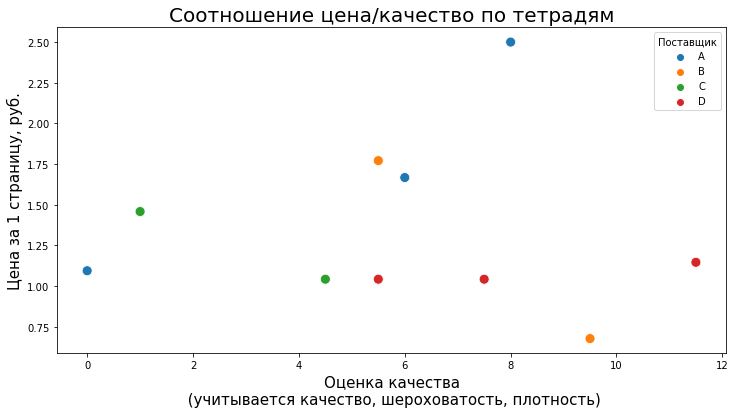

In [9]:
plt.figure(figsize=(12,6))
ax = sns.scatterplot(x=best_worst['Оценка_качества'], 
                     y=best_worst['Цена_за_стр'], 
                     hue=data['Поставщик'],
                     data=best_worst, s=100)

ax.set_title('Соотношение цена/качество по тетрадям', fontsize=20)
ax.set_xlabel('Оценка качества\n (учитывается качество, шероховатость, плотность)', fontsize=15)
ax.set_ylabel('Цена за 1 страницу, руб.', fontsize=15)

Наилучший для нас вариант находится в нижнем правом углу, где у тетрадей отмечается высокое качество и низкая цена. Как видно, в этом секторе больше всего тетрадей поставщика D.

Далее сгруппируем данные по Поставщикам и рассмотрим конкретные показатели

In [409]:
result_data = data_task_1.groupby('Поставщик').agg({
    'Оценка_качества': 'mean',
    'шероховатость_1мин_10макс': 'mean',
    'качество_обл_1мин_10макс': 'mean',
    'плотность_г_м2': 'mean',
    'кол_во_листов': lambda x: list(x),
    'цена_руб': lambda x: list(x),
    'Цена_за_стр': 'mean'}).style.highlight_min(color = 'lightblue', axis = 0).highlight_max(color = 'aqua', axis = 0)
result_data 

,Оценка_качества,шероховатость_1мин_10макс,качество_обл_1мин_10макс,плотность_г_м2,кол_во_листов,цена_руб,Цена_за_стр
Поставщик,,,,,,,
A,4.666667,7.333333,7.666667,4.333333,"[48, 64, 32]","[80, 70, 80]",1.753667
B,7.500000,4.000000,4.000000,7.500000,"[48, 96]","[85, 65]",1.224000
C,2.750000,6.500000,5.000000,4.250000,"[48, 48]","[50, 70]",1.250000
D,8.166667,4.666667,6.666667,6.166667,"[96, 48, 48]","[100, 50, 55]",1.076667


Мы видим, что поставщик D занимает второе место по уровню минимальной шероховатости, второе - по среднему качеству обложки и также по плотности. Это наилучший набор показателей качества по всем поставщикам. Средняя цена - минимальна, видим, что общая тетрадь в 96 листов стоит дороже, чем у поставщика B, однако низкая стоимость тетрадей по 48 листов уравновешивает эту разницу, делая среднюю цену ниже.

Таким образом, выбираем поставщика D, с ним мы сможем получить бОльшую прибыль и сохранить качество.

# Задание 2

Мы – организаторы некой многопользовательской онлайн-игры. На каждого игрока мы ведем игровую статистику, которая представлена в виде 127 игровых показателей. Каждый показатель характеризует поведение игрока в одной разновидности игровых ситуаций. Показатель является отношением числа произведенных игровых действий одного типа к числу возможностей данное действие произвести.

Есть ли среди игроков играющие одинаково, в каком-то одном стиле, на фоне остальных?
В ответе требуется указать все найденные группы игроков в виде таблицы с двумя колонками: groupNum  - номер группы и player - имя игрока, входящего в данную группу.

In [410]:
data_task_2 = pd.read_excel('Data.xlsx', sheet_name = 'Player_Groups', index_col='player')

In [411]:
data_task_2.head()

,stat1,stat2,stat3,stat4,stat5,stat6,stat7,stat8,stat9,stat10,...,stat118,stat119,stat120,stat121,stat122,stat123,stat124,stat125,stat126,stat127
player,,,,,,,,,,,,,,,,,,,,,
player1,0.000057,0.463585,NaN,0.269454,0.080972,NaN,0.480818,NaN,0.058824,NaN,...,0.433083,0.189568,0.393393,0.295057,0.251447,0.217143,NaN,0.287408,NaN,NaN
player2,0.000258,0.451477,NaN,0.280188,0.053763,NaN,0.449686,NaN,0.060870,NaN,...,0.419728,0.156165,0.403475,0.232939,0.149836,0.136318,NaN,0.242417,NaN,NaN
player3,0.000000,0.394161,NaN,0.259720,0.093137,NaN,0.498138,NaN,0.060150,NaN,...,0.424702,0.178597,0.374286,0.263825,0.258818,0.264657,NaN,0.264686,NaN,NaN
player4,0.000000,0.595941,NaN,0.285093,0.106122,NaN,0.409406,NaN,0.094595,NaN,...,0.405199,0.223855,0.410256,0.334586,0.270078,0.002787,NaN,0.250378,NaN,NaN
player5,0.000053,0.474469,NaN,0.237012,0.069284,NaN,0.464455,NaN,0.069588,NaN,...,0.447303,0.200082,0.364122,0.272970,0.307973,0.010024,NaN,0.284349,NaN,NaN


Задача кластеризации

Последовательность анализа
1. Проверка данных на пропуски, очистка, оценка распределения
2. Для понимания структуры данных и определения количества возможных групп - построение дендрограммы
3. На основе полученного количества групп используем несколько методов кластеризации
4. Оцениваем насколько схожи результаты и оцениваем кластеризацию в целом

In [412]:
#Смотрим основные характеристики данных
full_info = pd.DataFrame(data_task_2.dtypes, columns=['Type'])
full_info['Unique_val'] = data_task_2.nunique()
full_info['Values'] = data_task_2.count(axis=0)
full_info['No_value'] = data_task_2.isna().sum(axis=0)
full_info['min'] = data_task_2.min(axis=0)
full_info['mean'] = data_task_2.mean(axis=0).round(decimals = 2)
full_info['max'] = data_task_2.max(axis=0)
full_info['median'] = data_task_2.median(axis=0)
full_info.sort_values(by=['Type', 'Unique_val'])
full_info

,Type,Unique_val,Values,No_value,min,mean,max,median
stat1,float64,340,547,0,0.000000,0.00,0.015597,0.000025
stat2,float64,545,547,0,0.282395,0.50,0.684211,0.492730
stat3,float64,0,0,547,NaN,NaN,NaN,NaN
stat4,float64,546,547,0,0.151038,0.25,0.362096,0.242014
stat5,float64,534,547,0,0.018462,0.06,0.155235,0.062402
...,...,...,...,...,...,...,...,...
stat123,float64,539,547,0,0.000000,0.05,0.496816,0.015219
stat124,float64,0,0,547,NaN,NaN,NaN,NaN
stat125,float64,547,547,0,0.205401,0.26,0.339120,0.260097
stat126,float64,0,0,547,NaN,NaN,NaN,NaN


Все данные являются значениями с плавающей точкой; присутствуют показатели, по которым полностью отсутствуют значения.

In [413]:
print('Количество показателей без значений:{}'
      .format(full_info.No_value.loc[(full_info.No_value == 547)].count()))
print('Показатели с пропусками (количество пропусков):\n{}'
      .format(full_info.No_value.loc[(
          (full_info.No_value < 547) & (full_info.No_value > 0))]))

Количество показателей без значений:27
Показатели с пропусками (количество пропусков):
stat9        2
stat53     370
stat62     543
stat80       1
stat92     542
stat106      1
Name: No_value, dtype: int64


In [414]:
#Удаляем пустые столбцы
data_task_2.dropna(axis='columns', how='all', inplace=True)

#Удаляем столбцы с количеством пропусков больше 50% от количества наблюдений
data_task_2.drop(['stat53', 'stat62', 'stat92'], axis=1, inplace=True)

#Заменяем пропуски на среднее значение
data_task_2 = data_task_2.apply(lambda x: x.fillna(x.mean()), axis=0)
data_task_2.shape

(547, 97)

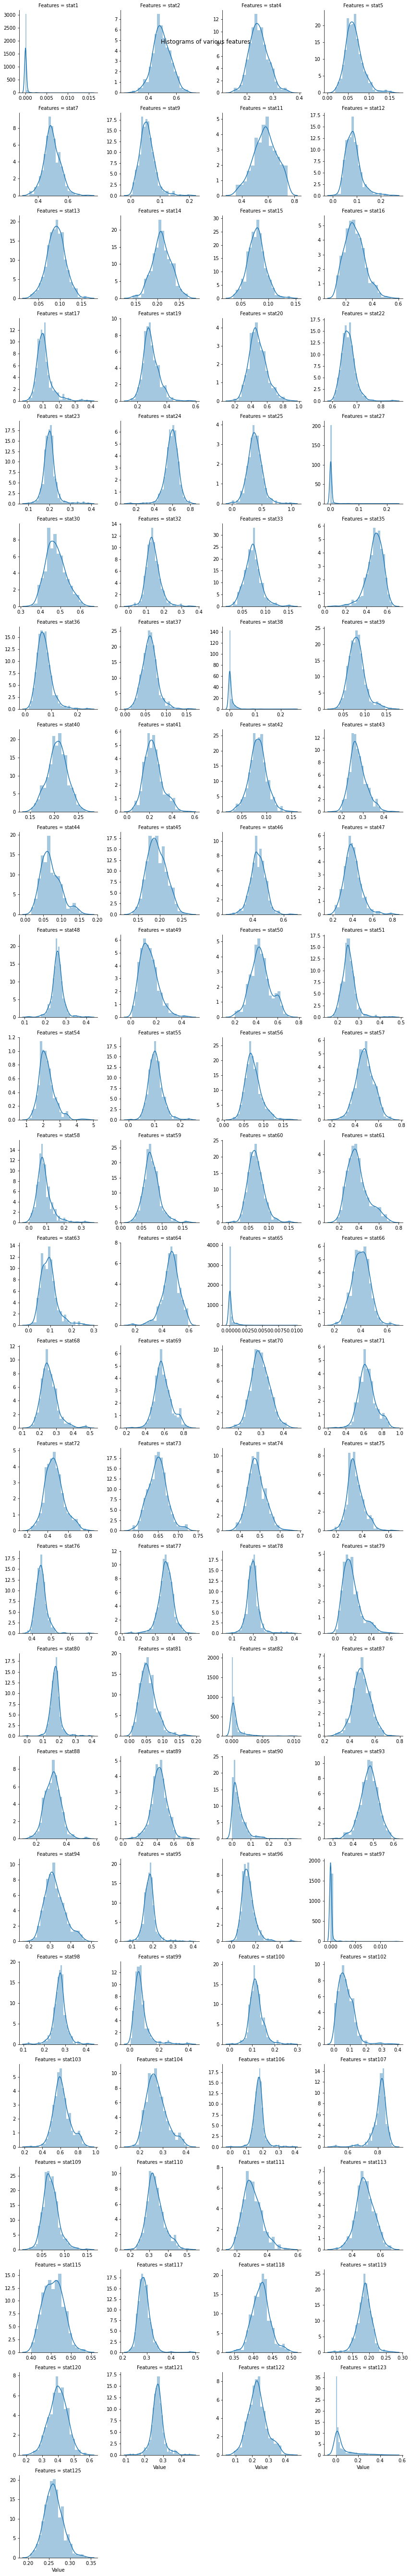

In [415]:
# Визуально оценим распределение кадого показателя
c_features = data_task_2.stack().reset_index().rename(
    columns={"level_1": "Features", 0: "Value"})

ax = sns.FacetGrid(data=c_features, col="Features",
                  col_wrap=4, sharex=False, sharey=False)
ax = ax.map(sns.distplot, "Value")

plt.subplots_adjust(top=0.7)
plt.suptitle("Histograms of various features")
plt.tight_layout() ;

Из графика гистограмм по всем признакам можно сказать, что распределение практически всех показателей близко к нормальному (из этого можно вывести, что замена пропусков на среднее значение - допустима). Сильных выбросов нет. Резко выделяются статистики под номерами 1, 27, 38, 65, 82, 90, 102 и 123, по ним очень большая часть значений равна нулю, а другие значения редки и остаются в хвосте распределения. Оставим их пока без преобразования.

Так как показателями являются относительные значения, отражающие отношение действий одного типа к числу возможностей произвести данное действие, то признаки измерены в одной шкале, из-за чего не будем стандартизовать данные.

**Перейдем к определению количества групп.** Самым наглядным образом определения количества групп является построение дендрограммы. 

*Пояснение: Дендрограмма строится на основе матрицы расстояний, чем точки ближе друг к другу, тем раньше они объединяются в отдельный кластер, последними объединяются, самые дальние точки. Таким образом, посмотрев на последние объединения, можно определить самые дальние группы.*

In [416]:
X = data_task_2

Text(0, 0.5, 'Кластерное расстояние')

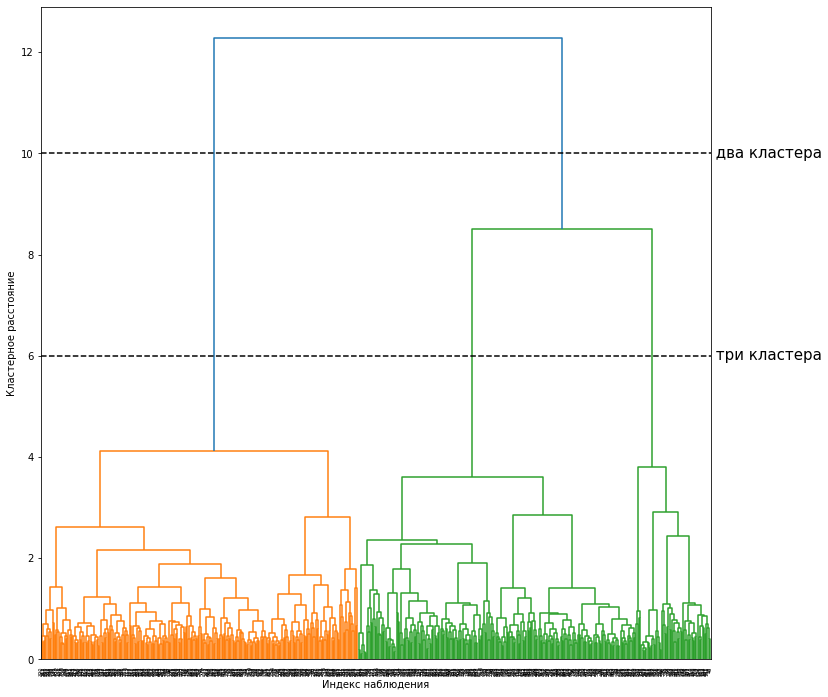

In [417]:
#Построение дендрограммы. В рамках анализа помимо Варда я использовала среднее и центройдное, 
#Вард показал наиболее структурное разбиение

plt.figure(figsize=(12,12))
linkage_array = ward(X)
dendrogram(linkage_array)
ax = plt.gca()
bounds = ax.get_xbound()

ax.plot(bounds, [10,10], '--', c='k')
ax.plot(bounds, [6, 6], '--', c='k')
ax.text(bounds[1], 10, ' два кластера', va='center', fontdict={'size': 15})
ax.text(bounds[1], 6, ' три кластера', va='center', fontdict={'size': 15})
plt.xlabel("Индекс наблюдения")
plt.ylabel("Кластерное расстояние")

Видно, что у данных наблюдается две основные группы, одна из которых делится еще на две части. Третья(самая правая группа) небольшая по численности, можно предположить, что они используют определенную специфичную стратегию ведения игры. В целом, можно было бы разделить на большее число групп, но данные там достаточно близко, поэтому остановимся на 3 группах.

Так как у нас нет целевой переменной, используем два разных способа кластеризации: аггломеративный метод и Kmeans. Если два метода примерно одинаково разделят наши данные можно будет говорить о хорошем качестве разбиения.

In [418]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels_aggl = cluster.fit_predict(X)

In [419]:
kmeans = KMeans(n_clusters=3, max_iter=600, random_state=0).fit(X)
labels_km = kmeans.labels_

Для оценки качества разбиения используем скорректированный/нескорректированный индексы Ренда и метрику скорректированной взаимной информации, они покажут насколько совпадает разбиение по аггломеративному способу и по Kmeans.

Далее для оценки кластеризации как таковой используем коэф. силуэта, который оценивает "компактность" кластера. *Для коэффициента силуэта лучшее значение равно 1, а худшее значение равно -1. Значения около 0 указывают на перекрывающиеся кластеры. Отрицательные значения обычно указывают на то, что образец был отнесен к неправильному кластеру, так как другой кластер более похож.*

In [420]:
print('Нескорректированный индекс Рэнда (диапазон от 0 до 1): {}'
      .format(round(metrics.rand_score(labels_aggl, labels_km), 3)))

print('Скорректированный индекс Рэнда (диапазон от -1 до 1): {}'
      .format(round(metrics.adjusted_rand_score(labels_aggl, labels_km), 3)))

print('Скорректированная взаимная информация (AMI) (от -1 до 1): {}'
     .format(round(metrics.adjusted_mutual_info_score(labels_aggl, labels_km), 3)))

print('Коэффициент силуэта для агломеративной кластеризации (от -1 до 1): {}'
     .format(round(metrics.silhouette_score(X, labels_aggl, metric='manhattan'), 3)))

print('Коэффициент силуэта для Kmeans (от -1 до 1)): {}'
     .format(round(metrics.silhouette_score(X, labels_km, metric='manhattan'), 3)))

Нескорректированный индекс Рэнда (диапазон от 0 до 1): 0.878
Скорректированный индекс Рэнда (диапазон от -1 до 1): 0.746
Скорректированная взаимная информация (AMI) (от -1 до 1): 0.693
Коэффициент силуэта для агломеративной кластеризации (от -1 до 1): 0.107
Коэффициент силуэта для Kmeans (от -1 до 1)): 0.11


Как мы видим два метода практически одинаково разделили наши данные на группы, даже скорректированные коэффициенты, которые учитывают случайность разбиения, достаточно высоки. Коэффициенты силуэта близки к нулю, однако они положительны, что говорит о правильном разбиении, но с наличием перекрывающих кластеров. У Kmeans силуэт лучше, поэтому в качестве результата оставим его.

In [421]:
data_task_2['groupNum'] = labels_km

In [422]:
#Для сведения приведем количество наблюдений в каждом кластере и средние характеристики по каждой статистике
mean_group_param = data_task_2.groupby('groupNum').mean()
    
number_of_players = data_task_2.groupby('groupNum')['groupNum'].count().values
mean_group_param.insert(loc = 0, column = 'Number_of_players', value = number_of_players)

mean_group_param.style.highlight_min(color='lightblue', axis=0).highlight_max(color='aqua', axis=0)

,Number_of_players,stat1,stat2,stat4,stat5,stat7,stat9,stat11,stat12,stat13,stat14,stat15,stat16,stat17,stat19,stat20,stat22,stat23,stat24,stat25,stat27,stat30,stat32,stat33,stat35,stat36,stat37,stat38,stat39,stat40,stat41,stat42,stat43,stat44,stat45,stat46,stat47,stat48,stat49,stat50,stat51,stat54,stat55,stat56,stat57,stat58,stat59,stat60,stat61,stat63,stat64,stat65,stat66,stat68,stat69,stat70,stat71,stat72,stat73,stat74,stat75,stat76,stat77,stat78,stat79,stat80,stat81,stat82,stat87,stat88,stat89,stat90,stat93,stat94,stat95,stat96,stat97,stat98,stat99,stat100,stat102,stat103,stat104,stat106,stat107,stat109,stat110,stat111,stat113,stat115,stat117,stat118,stat119,stat120,stat121,stat122,stat123,stat125
groupNum,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,74,0.000276,0.519238,0.257163,0.066838,0.579912,0.058206,0.642737,0.121285,0.092833,0.202413,0.087042,0.204284,0.100871,0.376573,0.578886,0.673842,0.197950,0.583035,0.398236,0.001851,0.545524,0.159790,0.080588,0.489156,0.097655,0.065515,0.005217,0.098905,0.210895,0.274611,0.092024,0.341302,0.087577,0.183932,0.394039,0.378303,0.258008,0.193552,0.533578,0.248252,3.100804,0.115888,0.088164,0.522017,0.083947,0.080964,0.072848,0.467589,0.138273,0.460437,0.000318,0.372372,0.259165,0.698339,0.314136,0.748414,0.570856,0.649533,0.552660,0.449823,0.450849,0.361826,0.197950,0.218757,0.171472,0.074464,0.000784,0.508942,0.284175,0.418823,0.049291,0.484676,0.388884,0.180784,0.159548,0.000213,0.272074,0.067335,0.132541,0.075465,0.733410,0.328876,0.171472,0.824058,0.079300,0.408249,0.273022,0.516040,0.481955,0.274754,0.413130,0.192970,0.383152,0.271851,0.260504,0.039605,0.239467
1,245,0.000122,0.479584,0.236013,0.062596,0.454240,0.053883,0.545809,0.069970,0.091997,0.211369,0.076420,0.300084,0.108720,0.255014,0.453387,0.664917,0.203112,0.585171,0.372742,0.003111,0.444085,0.130246,0.070089,0.466284,0.062915,0.058265,0.008566,0.076811,0.204241,0.218359,0.081357,0.248510,0.063258,0.194704,0.454119,0.422131,0.261693,0.121717,0.397003,0.257151,1.851305,0.100194,0.067783,0.467147,0.087637,0.072179,0.067680,0.357566,0.076268,0.467688,0.000198,0.426640,0.265565,0.539192,0.286370,0.591067,0.426332,0.651702,0.450617,0.305712,0.452001,0.368046,0.203112,0.168913,0.177254,0.049671,0.000624,0.483103,0.327326,0.439882,0.029017,0.475911,0.293163,0.186814,0.129929,0.000100,0.276890,0.078884,0.111586,0.078515,0.568583,0.245531,0.177254,0.808173,0.066439,0.298274,0.321965,0.476892,0.444903,0.297727,0.427783,0.185795,0.402558,0.272595,0.221398,0.069264,0.273415
2,228,0.000089,0.503813,0.251968,0.066130,0.508755,0.058351,0.589894,0.087541,0.088988,0.210468,0.078044,0.254567,0.108083,0.303264,0.488943,0.663033,0.198483,0.609605,0.390597,0.000998,0.489253,0.143199,0.072991,0.494186,0.075920,0.061902,0.004481,0.081016,0.207697,0.239505,0.081977,0.287397,0.074353,0.193503,0.427632,0.385930,0.257896,0.151926,0.454066,0.247729,2.343938,0.105804,0.075471,0.492004,0.088645,0.074506,0.067208,0.392658,0.097442,0.466606,0.000237,0.384820,0.249666,0.600363,0.306820,0.649848,0.478346,0.645976,0.495757,0.364302,0.444105,0.362595,0.198483,0.190145,0.173942,0.059389,0.000620,0.507105,0.298570,0.421711,0.042931,0.484827,0.336242,0.182117,0.141502,0.000062,0.271843,0.071705,0.119884,0.069735,0.630656,0.281744,0.173942,0.819257,0.070855,0.345504,0.291754,0.501042,0.459292,0.283142,0.414774,0.185258,0.402940,0.268845,0.233824,0.043181,0.254859


**Результат в таблице result**

In [423]:
result = data_task_2[['groupNum']]
result.head(10)

,groupNum
player,
player1,1
player2,2
player3,1
player4,1
player5,1
player6,2
player7,1
player8,1
player9,2


# Задание 3

Предположим в условиях задачи 2 (в том же формате данных) у нас уже есть группа игроков (первая часть таблицы, все игроки с именами gr_player…) с одинаковой игрой. Какими диапазонами показателей характеризуется стиль игры данной группы? В ответе требуется в любой форме указать алгоритм отнесения произвольного игрока по его игровым показателям к данной группе, а также продемонстрировать данный алгоритм при ответе на вопрос: кого из на указанных игроков из второй части таблицы (зеленая часть, имена new_player…) можно отнести к данной группе и почему нельзя остальных?

In [424]:
data_task_3 = pd.read_excel('Data.xlsx', sheet_name = 'Group_Style_By_stats', index_col='player')

In [425]:
data_task_3.shape

(53, 127)

Задача отнесения к группе по показателям

Алгоритм анализа
1. Проверка данных на пропуски, очистка, оценка распределения
2. Для оценки показателей, которые характеризуют данный стиль игры, и определения диапазона воспользуемся описательной статистикой, которая покажет нам средние величины, рамах данных. Можно предположить, что раз у этих игроков единый стиль игры, то вариация по основным показателям, отражающим конкретно этот стиль, будет минимальна.
3. Для оценки включения игроков в группу используем два способа:
- оценим сколько показателей входят в диапазон межквартильного размаха, если большая часть входит, то можно считать стратегию этого нового игрока схожей со стратегией группы.
- на основе матрицы расстояний оценить близость показателей новых игроков с показателями группы, построить дендрограмму и посмотреть, на каком этапе игрок присоединяется к кластеру.

In [426]:
#Смотрим основные характеристики данных вместе с новыми игроками, 
#чтобы исключить пустые столбцы и заполнить пропуски
full_info = pd.DataFrame(data_task_3.dtypes, columns=['Type'])
full_info['Unique_val'] = data_task_3.nunique()
full_info['Values'] = data_task_3.count(axis=0)
full_info['No_value'] = data_task_3.isna().sum(axis=0)
full_info['min'] = data_task_3.min(axis=0)
full_info['mean'] = data_task_3.mean(axis=0).round(decimals = 2)
full_info['max'] = data_task_3.max(axis=0)
full_info['median'] = data_task_3.median(axis=0)
full_info.sort_values(by=['Type', 'Unique_val'])
full_info

,Type,Unique_val,Values,No_value,min,mean,max,median
stat1,float64,26,53,0,0.000000,0.00,0.000188,0.000000
stat2,float64,53,53,0,0.425349,0.54,0.623913,0.542488
stat3,float64,0,0,53,NaN,NaN,NaN,NaN
stat4,float64,53,53,0,0.165808,0.21,0.284902,0.210689
stat5,float64,53,53,0,0.045775,0.08,0.118987,0.081081
...,...,...,...,...,...,...,...,...
stat123,float64,53,53,0,0.000000,0.01,0.034413,0.007303
stat124,float64,0,0,53,NaN,NaN,NaN,NaN
stat125,float64,53,53,0,0.237372,0.26,0.287544,0.263282
stat126,float64,0,0,53,NaN,NaN,NaN,NaN


In [427]:
print('Количество показателей без значений:{}'
      .format(full_info.No_value.loc[(full_info.No_value == 53)].count()))
print('Показатели с пропусками (количество пропусков):\n{}'
      .format(full_info.No_value.loc[(
          (full_info.No_value < 53) & (full_info.No_value > 0))]))

Количество показателей без значений:26
Показатели с пропусками (количество пропусков):
stat34    52
stat53    24
stat62    48
stat92    49
Name: No_value, dtype: int64


In [428]:
#Удаляем пустые столбцы
data_task_3.dropna(axis='columns', how='all', inplace=True)
#Исключаем показатели с количеством пропусков больше 50% наблюдений
data_task_3.drop(['stat34', 'stat53', 'stat62', 'stat92'], axis=1, inplace=True)
data_task_3.shape

(53, 97)

In [429]:
#Рассчитываем основные описательные статистики без учета 4 новых игроков
data = data_task_3.iloc[:-4, :].describe().T.sort_values('std')
data.head()

,count,mean,std,min,25%,50%,75%,max
stat1,49.0,0.000029,0.000044,0.0,0.0,0.000000,0.000037,0.000188
stat97,49.0,0.000024,0.000091,0.0,0.0,0.000000,0.000000,0.000482
stat65,49.0,0.000086,0.000189,0.0,0.0,0.000000,0.000094,0.001071
stat27,49.0,0.000153,0.000222,0.0,0.0,0.000041,0.000253,0.001035
stat82,49.0,0.000198,0.000366,0.0,0.0,0.000061,0.000190,0.002142


In [430]:
#Добавляем к основным статистикам коэф. вариации, который покажет долю изменений относительно среднего значения
data['Variance_pc'] = data['std'] / data['mean'] * 100
#Рассчитываем основные диапазоны
data['Размах_max_min'] = data['max'] - data['min']
data['Межквартиль_размах'] = data['75%'] - data['25%']
data.sort_values('Variance_pc', inplace=True)
data = data.round(4)
data.head(10)

,count,mean,std,min,25%,50%,75%,max,Variance_pc,Размах_max_min,Межквартиль_размах
stat107,49.0,0.8396,0.0150,0.8154,0.8315,0.8356,0.8484,0.8763,1.7813,0.0610,0.0169
stat73,49.0,0.7081,0.0144,0.6797,0.6980,0.7070,0.7185,0.7461,2.0309,0.0663,0.0205
stat22,49.0,0.7233,0.0182,0.6881,0.7115,0.7204,0.7312,0.7675,2.5227,0.0793,0.0197
stat115,49.0,0.5248,0.0196,0.4852,0.5112,0.5256,0.5401,0.5629,3.7427,0.0778,0.0289
stat125,49.0,0.2643,0.0102,0.2446,0.2584,0.2620,0.2695,0.2875,3.8476,0.0429,0.0111
stat7,49.0,0.6195,0.0251,0.5614,0.6042,0.6206,0.6338,0.6856,4.0503,0.1242,0.0296
stat69,49.0,0.6948,0.0285,0.6046,0.6787,0.7023,0.7136,0.7473,4.1058,0.1427,0.0349
stat118,49.0,0.4514,0.0189,0.4245,0.4395,0.4452,0.4620,0.5030,4.1853,0.0785,0.0226
stat77,49.0,0.3510,0.0148,0.3236,0.3393,0.3501,0.3604,0.3802,4.2079,0.0566,0.0211
stat50,49.0,0.7264,0.0306,0.6026,0.7135,0.7257,0.7470,0.7859,4.2143,0.1834,0.0336


Данные отсортированы по показателю вариации, с такой точки зрения, что чем конкретнее показатель описывает группу, тем меньше разброс этого показателя по нашей выборке. Есть вероятность, что показатель в целом слабо вариативен, что было бы идеально проверить на всей совокупности, но пока остановимся на этом. Диапазоны основных характеристик представлены в таблице.

In [431]:
#Для оценки включения нового игрока в группу, добавим их к описательной статистике
data[['new_player1', 'new_player2', 'new_player3', 'new_player4']] = data_task_3.iloc[-4:,:].T

In [432]:
#Оценим количество показателей каждого нового игрока, которые находятся в пределах межквартильного размаха
print('Количество показателей new_player1, входящих в межквартильный размах: {}'
      .format(((data['25%'] < data.new_player1) & (data.new_player1 < data['75%'])).sum()))

print('Количество показателей new_player2, входящих в межквартильный размах: {}'
      .format(((data['25%'] < data.new_player2) & (data.new_player2 < data['75%'])).sum()))

print('Количество показателей new_player3, входящих в межквартильный размах: {}'
      .format(((data['25%'] < data.new_player3) & (data.new_player3 < data['75%'])).sum()))

print('Количество показателей new_player4, входящих в межквартильный размах: {}'
      .format(((data['25%'] < data.new_player4) & (data.new_player4 < data['75%'])).sum()))

print('Количество показателей:{}'.format(data.shape[0]))

Количество показателей new_player1, входящих в межквартильный размах: 23
Количество показателей new_player2, входящих в межквартильный размах: 44
Количество показателей new_player3, входящих в межквартильный размах: 45
Количество показателей new_player4, входящих в межквартильный размах: 23
Количество показателей:97


Из полученного результата можно сделать вывод, что у **new_player2 и new_player3** чуть меньше половины показателей входит в указанные рамки, из-за чего можно определить их как игроков соответствующих стратегии представленной группы.

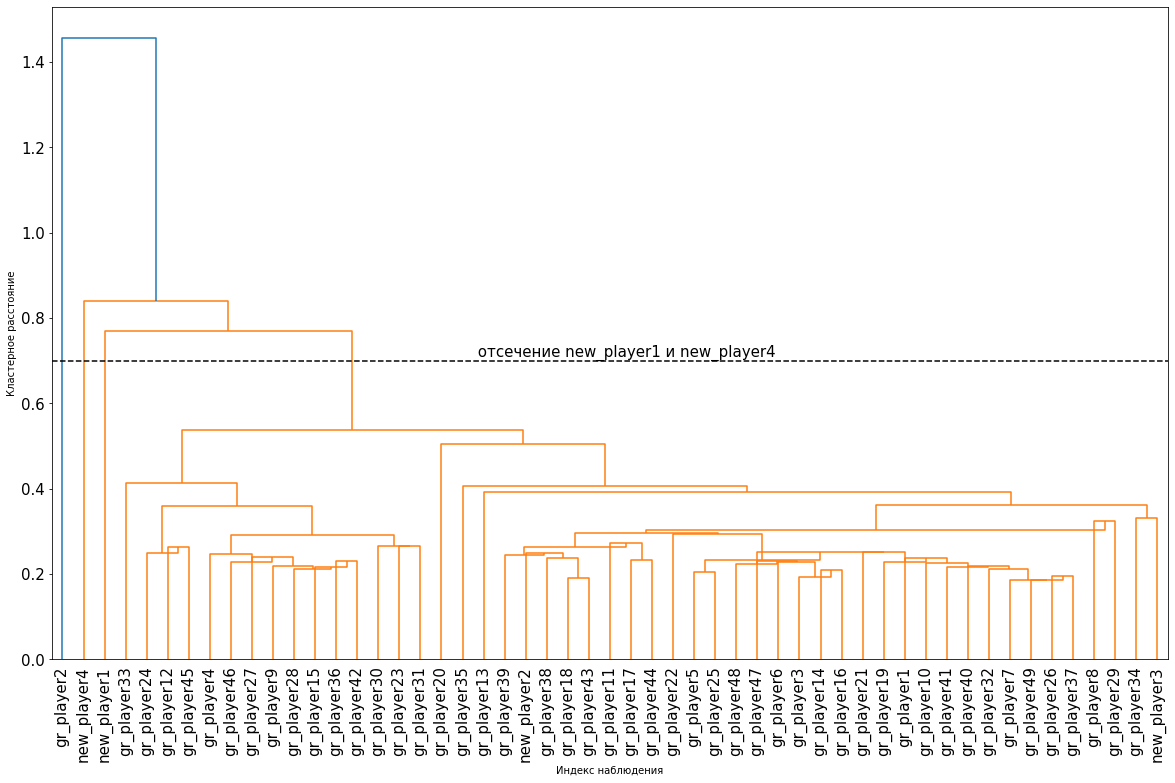

In [433]:
#Оценим схожесть игроков по матрице расстояний и построим дендрит 
#(были использованы методы Варда, среднего и центроидный метод,
#резудьтаты были одинаковы, однако центройдный метод лучше визуализирует данные)

plt.figure(figsize=(20,12))
linkage_array = centroid(data_task_3)
dendrogram(linkage_array, labels=data_task_3.index ,distance_sort='ascending')
ax = plt.gca()
bounds = ax.get_xbound()

ax.plot(bounds, [0.7,0.7], '--', c='k')
ax.text(200, 0.7, ' отсечение new_player1 и new_player4', va='bottom', fontdict={'size': 15})

plt.xlabel("Индекс наблюдения")
plt.ylabel("Кластерное расстояние")
plt.tick_params(axis='both', which='major', labelsize=15)

Как видно, new_player1 и new_player4 добавляются к основному кластеру в последнюю очередь, что говорит об удаленности данных. Из-за чего принятое решение об определении new_player2 и new_player3 к группе игроков с единой стратегией подтверждается.